<a href="https://colab.research.google.com/github/qusaysellat/tensorflow-tutorial/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**THIS IS A SIMPLE AUTO-ENCODER FOR** *MNIST DATASET*

>NAME : [QUSAY SELLAT](https://github.com/qusaysellat)

>FOR MORE INFORMATION ABOUT 'MNIST' VISIT
[THIS SITE](http://yann.lecun.com/exdb/mnist/)

In [0]:
# first, lets import the libraries we are going to use

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
# then, we load the MNIST dataset on which we are going to test our model

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/', one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from t

In [0]:
# lets try to play with this data set

# lets see the dimensions of train, validation, and test datasets - note that mnist is a named tupple
print("dimensions of images and labels of training set")
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

print("dimensions of images and labels of validation set")
print(mnist[1].images.shape)
print(mnist[1].labels.shape)

print("dimensions of images and labels of testing set")
print(getattr(mnist, 'test').images.shape)
print(getattr(mnist, 'test').labels.shape)

dimensions of images and labels of training set
(55000, 784)
(55000, 10)
dimensions of images and labels of validation set
(5000, 784)
(5000, 10)
dimensions of images and labels of testing set
(10000, 784)
(10000, 10)


In [0]:
# lets take a sample of our data and discover its values
print('the first 8 labels in the testing set:')
print(mnist[2].labels[:8, : ])

the first 8 labels in the testing set:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


first 8 digits in the testing set:


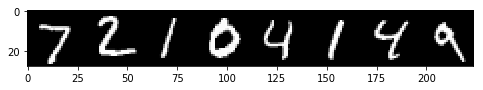

In [0]:
# now lets draw the sample we have just viewed

canvas = np.zeros((28, 28 * 8))
for i in range(8):
  canvas[:, 28 * i : 28 * (i + 1)] = mnist[2].images[i, :].reshape([28 ,28])
 
print("first 8 digits in the testing set:")
plt.figure(figsize = (8, 64))
plt.imshow(canvas, origin = 'upper', cmap ='gray')
plt.show()

In [0]:
# now lets define hyperparameters 

LR = 0.001
batch_size = 128
steps = 501
dropout = 0.8

# next we define network structure

I = 784 # number of pixels
O = 10 # number of classes

In [0]:
# lets define used placeholders

X = tf.placeholder(tf.float32, shape = (None, I))
Y = tf.placeholder(tf.float32, shape = (None, O))
d = tf.placeholder(tf.float32)

In [0]:
# lets define weights and biases of the network

Weights = {
    'conv_w_1' : tf.Variable(tf.random_normal([5, 5, 1, 16])),
    'conv_w_2' : tf.Variable(tf.random_normal([5, 5, 16, 32])),
    'conv_w_3' : tf.Variable(tf.random_normal([5, 5, 32, 64])),
    'conv_w_4' : tf.Variable(tf.random_normal([5, 5, 64, 128])),
    'fully_w_1' : tf.Variable(tf.random_normal([7*7*128, 1024])),
    'fully_w_2' : tf.Variable(tf.random_normal([1024, O]))
}

biases = {
    'conv_b_1' : tf.Variable(tf.random_normal([16])),
    'conv_b_2' : tf.Variable(tf.random_normal([32])),
    'conv_b_3' : tf.Variable(tf.random_normal([64])),
    'conv_b_4' : tf.Variable(tf.random_normal([128])),
    'fully_b_1' : tf.Variable(tf.random_normal([1024])),
    'fully_b_2' : tf.Variable(tf.random_normal([O]))
}

In [0]:
# now we will construct helping functions

# single convolutional operation
def conv_op(x, W, b, stride = 1) :
  x = tf.nn.conv2d(x, W, strides = [1, stride, stride, 1], padding = 'SAME' )
  x = tf.nn.bias_add(x, b)
  x = tf.nn.relu(x)
  return x

# single max pool operation
def maxpool_op(x, k = 2) :
  x = tf.nn.max_pool2d(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')
  return x

# model
def conv_model(x, Weights, biases, d, phase = 'TESTING') :
  
  # reshape x to appropriate size for convolutional operations
  x = tf.reshape(x, shape = [-1, 28, 28, 1])
  
  # first convolutional layer
  x = conv_op(x, Weights['conv_w_1'], biases['conv_b_1'])
  x = conv_op(x, Weights['conv_w_2'], biases['conv_b_2'])
  x = maxpool_op(x)
  
  # second convolutional layer
  x = conv_op(x, Weights['conv_w_3'], biases['conv_b_3'])
  x = conv_op(x, Weights['conv_w_4'], biases['conv_b_4'])
  x = maxpool_op(x)
  
  
  # fully connected layers
  
  # first fully connected layer
  x = tf.reshape(x, [-1, Weights['fully_w_1'].shape[0]])
  x = tf.add(tf.matmul(x, Weights['fully_w_1']), biases['fully_b_1'])
  x = tf.nn.relu(x)
  
  # perform dropout if in training phase
  if phase == 'TRAINING' :
    x = tf.nn.dropout(x, dropout)
  
  # second fully connected layer
  x = tf.add(tf.matmul(x, Weights['fully_w_2']), biases['fully_b_2'])
  
  return x

In [0]:
# now lets complete our model

# define logits and predictions
logits = conv_model(X, Weights, biases, d, phase = 'TRAINING')
preds = tf.nn.softmax(logits)

# define the loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = logits))

# define the optimizer
optimizer = tf.train.AdamOptimizer(LR).minimize(loss)

# find the accuracy
correct_eval = tf.equal(tf.arg_max(preds, 1), tf.arg_max(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_eval, tf.float32))

# these are for testing phase without dropout
logits_test = conv_model(X, Weights, biases, d, phase = 'TESTING')
preds_test = tf.nn.softmax(logits)
predictions_test = tf.arg_max(preds_test, 1)
correct_eval_test = tf.equal(tf.arg_max(preds_test, 1), tf.arg_max(Y, 1))
accuracy_test = tf.reduce_mean(tf.cast(correct_eval_test, tf.float32))

# tf initializer
init = tf.global_variables_initializer()

# to save the results
saver = tf.train.Saver()

W0906 09:55:26.002973 140188133250944 deprecation.py:506] From <ipython-input-9-7bc5ee8c6ee7>:38: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0906 09:55:26.019219 140188133250944 deprecation.py:323] From <ipython-input-10-30c80171a94f>:5: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

W0906 09:55:26.414544 140188133250944 deprecation.py:323] From <ipython-input-10-30c80171a94f>:11: arg_max (from tensorflow.python.ops.gen_math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.math.argmax`

step 0 : loss : 45653248.0000, accuracy : 0.102
step 10 : loss : 17343322.0000, accuracy : 0.188
step 20 : loss : 9713394.0000, accuracy : 0.359
step 30 : loss : 3916027.0000, accuracy : 0.625
step 40 : loss : 3110550.0000, accuracy : 0.648
step 50 : loss : 2590606.0000, accuracy : 0.742
step 60 : loss : 3621199.7500, accuracy : 0.688
step 70 : loss : 2430561.0000, accuracy : 0.758
step 80 : loss : 2173960.0000, accuracy : 0.727
step 90 : loss : 1142284.2500, accuracy : 0.805
step 100 : loss : 1243579.5000, accuracy : 0.805
step 110 : loss : 1235716.5000, accuracy : 0.797
step 120 : loss : 1176762.6250, accuracy : 0.859
step 130 : loss : 1234315.0000, accuracy : 0.812
step 140 : loss : 831075.0000, accuracy : 0.844
step 150 : loss : 592791.7500, accuracy : 0.852
step 160 : loss : 1100632.8750, accuracy : 0.844
step 170 : loss : 885008.5000, accuracy : 0.859
step 180 : loss : 946271.5000, accuracy : 0.875
step 190 : loss : 758905.8750, accuracy : 0.875
step 200 : loss : 1248531.6250, ac

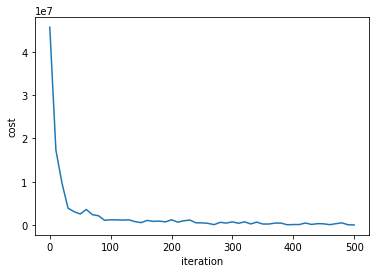

In [0]:
# lets train our model and see the results
with tf.Session() as sess :
  
  # run tf initializer
  sess.run(init)
  
  # initialize training cost list
  errors = list()
  
  for i in range(steps) :
    
    # get next batch
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    
    # run optimizer
    _ = sess.run(optimizer, feed_dict = {X : batch_x, Y : batch_y, d : dropout})
    
    if i % 10 == 0 :
      
      # calculate current loss and accuracy
      l, a = sess.run([loss, accuracy], feed_dict = {X : batch_x, Y : batch_y, d : dropout})
      
      # print current loss and accuracy
      print('step ' + str(i) + " : " + "loss : " + "{:.4f}".format(l) + ", accuracy : " + "{:.3f}".format(a))
      
      # add calculated loss to error list
      
      errors.append([i, l])
  
  print('training phase finished successfully !')
  
  print('notice how calculated cost changes with iterations :')
  plt.xlabel('iteration')
  plt.ylabel('cost')
  plt.plot([i[0] for i in errors], [i[1] for i in errors])
  plt.show()
  
  # save the variables
  saving_path = saver.save(sess, '/tmp/cnnmodel.ckpt')

W0906 10:07:20.021445 140188133250944 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


the accuracy on the testing set is: 0.927
lets see how our model classifies first 8 images in the testing set: 


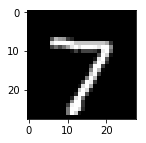

our algorithm predicted above digit as : 7



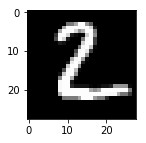

our algorithm predicted above digit as : 2



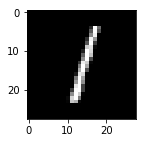

our algorithm predicted above digit as : 1



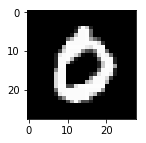

our algorithm predicted above digit as : 0



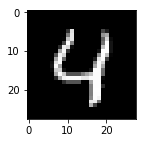

our algorithm predicted above digit as : 4



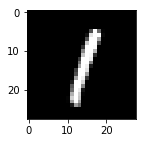

our algorithm predicted above digit as : 1



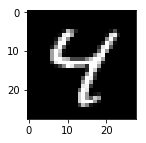

our algorithm predicted above digit as : 4



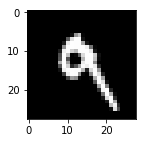

our algorithm predicted above digit as : 9


now lets see a sample of the images our model failed to classify


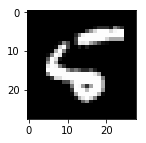

our algorithm predicted above digit as : 6



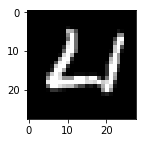

our algorithm predicted above digit as : 0



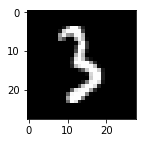

our algorithm predicted above digit as : 2



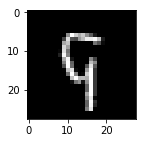

our algorithm predicted above digit as : 7



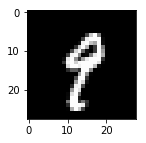

our algorithm predicted above digit as : 4



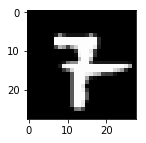

our algorithm predicted above digit as : 8



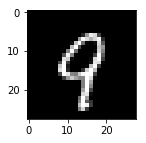

our algorithm predicted above digit as : 4



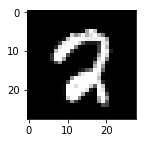

our algorithm predicted above digit as : 9



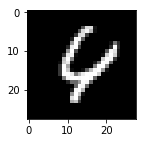

our algorithm predicted above digit as : 6



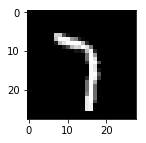

our algorithm predicted above digit as : 3



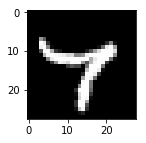

our algorithm predicted above digit as : 4



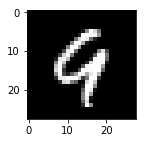

our algorithm predicted above digit as : 4



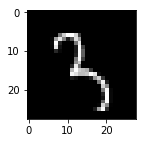

our algorithm predicted above digit as : 2



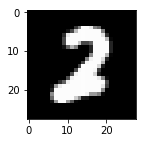

our algorithm predicted above digit as : 8



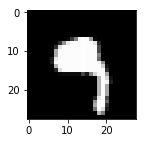

our algorithm predicted above digit as : 5



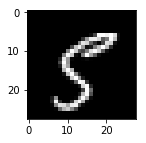

our algorithm predicted above digit as : 8



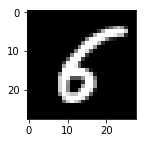

our algorithm predicted above digit as : 5



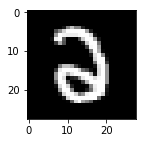

our algorithm predicted above digit as : 3



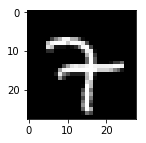

our algorithm predicted above digit as : 3



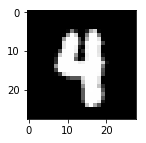

our algorithm predicted above digit as : 9



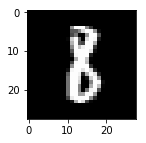

our algorithm predicted above digit as : 6



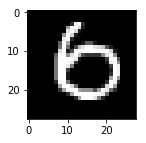

our algorithm predicted above digit as : 0



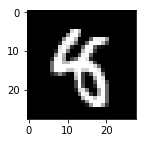

our algorithm predicted above digit as : 4



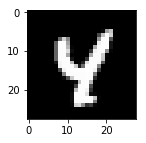

our algorithm predicted above digit as : 8



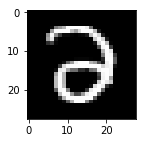

our algorithm predicted above digit as : 3



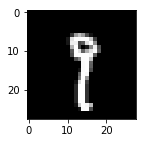

our algorithm predicted above digit as : 7



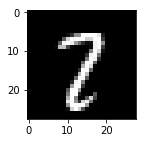

our algorithm predicted above digit as : 7



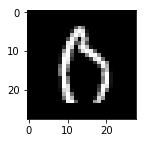

our algorithm predicted above digit as : 5



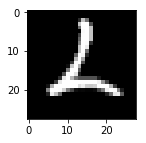

our algorithm predicted above digit as : 1



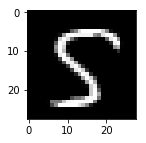

our algorithm predicted above digit as : 8



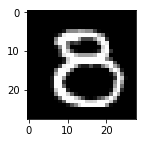

our algorithm predicted above digit as : 5



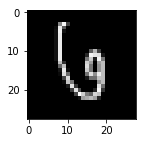

our algorithm predicted above digit as : 4



In [0]:
with tf.Session() as sess : 
  
  saver.restore(sess, '/tmp/cnnmodel.ckpt')
  
  x_test = mnist.test.images
  y_test = mnist.test.labels
  predictions, correct, accuracy = sess.run([predictions_test, correct_eval_test, accuracy_test], feed_dict = {X : x_test, Y : y_test, d : 1.0})
  
  print('the accuracy on the testing set is: ' + '{:.3f}'.format(accuracy))
  
  print('lets see how our model classifies first 8 images in the testing set: ')

  for i in range(8):
    
    plt.figure(figsize = (2, 2))
    plt.imshow(x_test[i, : ].reshape([28, 28]), origin = 'upper', cmap = 'gray')
    plt.show()
    print('our algorithm predicted above digit as : ' + str(predictions[i]) + '\n')
    
  print('\nnow lets see a sample of the images our model failed to classify')
  
  sample_size = 0
  
  for i in range(y_test.shape[0]):
    if correct[i] == False :
      plt.figure(figsize = (2, 2))
      plt.imshow(x_test[i, : ].reshape([28, 28]), origin = 'upper', cmap = 'gray')
      plt.show()
      print('our algorithm predicted above digit as : ' + str(predictions[i]) + '\n')
      sample_size += 1
      if sample_size == 32 :
        break